In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
from tensorflow.keras import layers, optimizers, models, callbacks, applications
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shutil import copy2

In [3]:
train_dir = '../input/train/train/'
test_dir = '../input/test/test/'

df = pd.read_csv('../input/train.csv')
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
labels = df['has_cactus'].tolist()
img_paths = df['id'].tolist()

**Visualize images**

Here we plot random images from the dataset with labels set as title

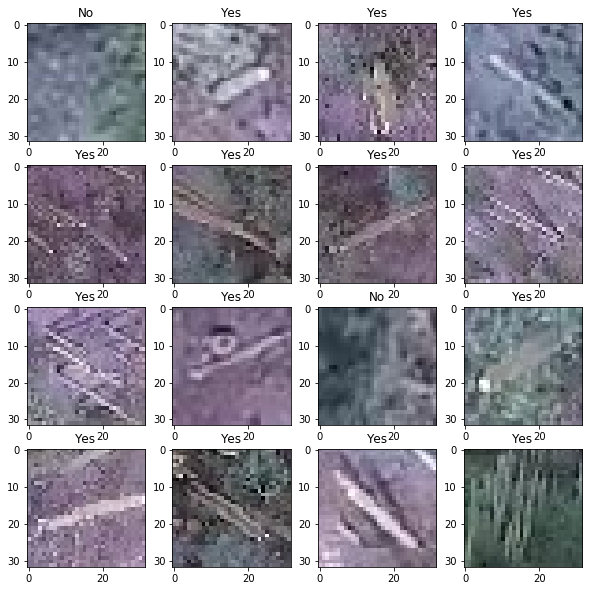

In [5]:
import cv2

indices = np.random.randint(0, 17500, size = 16)
fig = plt.figure(figsize = (10, 10))

for i in range(16):
    image = cv2.imread('../input/train/train/{}'.format(img_paths[indices[i]]))
    plot = fig.add_subplot(4, 4, i + 1)
    title = 'No' if labels[indices[i]] == 0 else 'Yes'
    plot.set_title(title)
    plot.imshow(image)
    
plt.show()

**Create The Model**

As we are more or less done with the data preparation phase it is high time that we build the model.

In [33]:
def build_model():
    
    model_input = layers.Input(shape = [32, 32, 3])
    X = applications.densenet.DenseNet121(weights = 'imagenet', include_top = False, classes = 1)(model_input)
    X = layers.Flatten()(X)
    model_output = layers.Dense(1, activation = 'sigmoid')(X)
    
    return models.Model(model_input, model_output)
    


**Compiling Model**

Here we compile the model. As we have only one value as output indicating 0 or 1 *binary_crossentropy* is the loss that should be chosen and we choose *adam* as the optimizer.

In [34]:
model = build_model()
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(lr = 0.0001), metrics = ['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


**Initializing the generator**

Now we should prepare the model for training. We take the help of ***ImageDataGenerator*** class over here which will take care of a lot of the hard tasks like prepairing batches, data augmentation, etc. during trainnig of the model. Data augmentation is important and is mostly done to avoid overfitting. Here we also rescale the data, where we transform the pixels into values between 0 and 1.

In [28]:
def split_dataframe(csv_file):
    df = pd.read_csv(csv_file)
    
    train_df = df.iloc[:14000, :]
    train_df['has_cactus'] = train_df['has_cactus'].apply(str)
    val_df = df.iloc[14000:, :]
    val_df['has_cactus'] = val_df['has_cactus'].apply(str)
    
    return train_df, val_df

train_df, val_df = split_dataframe('../input/train.csv')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, val_df = split_dataframe('../input/train.csv')

train_gen = ImageDataGenerator(
            rescale = 1./255,
            validation_split = 0.15,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 10
        )

train_gen = train_gen.flow_from_dataframe(
            dataframe = train_df,
            directory = train_dir,
            x_col = 'id',
            y_col = 'has_cactus',
            target_size = (32, 32),
            color_mode = 'rgb',
            class_mode = 'binary',
            batch_size = 128,
            shuffle = True,
        )

val_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)

val_gen = val_gen.flow_from_dataframe(
            dataframe = val_df,
            directory = train_dir,
            x_col = 'id',
            y_col = 'has_cactus',
            target_size = (32, 32),
            color_mode = 'rgb',
            class_mode = 'binary',
            batch_size = 128,
            shuffle = True,
        )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Found 14000 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


**Training the model**

Callbacks are helpful to conduct a meaningful training of the model. Here we use two callbacks.

The ***checkpoint*** is used to

*   save the model performing best on the validation set (which actually is the measure of the extent of generalizability of the model on unseen data) through each epoch and
*   save model in each epoch so that we can manually choose, the model performing best on the validation set, for production once the training ends.
(that is how we choose the model performing best throughout the training)

The ***reduce_lr*** is used to ensure a connsistent descent of the loss. Here the learning rate is reduced by a specified factor when the curve tends to plateau.

Then we use the ***fit_generator*** function to train the model.



In [39]:
checkpoint = callbacks.ModelCheckpoint(
            'model.h5',
            monitor = 'val_loss',
            verbose = 0,
            save_best_only = True,
            save_weights_only = False,
            mode = 'auto'
        )

regulate_lr = callbacks.ReduceLROnPlateau(monitor = 'val_loss', min_lr = 1e-5, patience = 3)

model.fit_generator(
    train_gen,
    steps_per_epoch = 14000 // 128,
    validation_data = val_gen,
    validation_steps = 14000 // 128,
    epochs = 60,
    callbacks = [checkpoint, regulate_lr]
)


Epoch 1/10
110/110 [==============================] - 34s 310ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0115 - val_acc: 0.9960
Epoch 2/10
110/110 [==============================] - 33s 300ms/step - loss: 0.0029 - acc: 0.9990 - val_loss: 0.0119 - val_acc: 0.9957
Epoch 3/10
110/110 [==============================] - 34s 307ms/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0108 - val_acc: 0.9971
Epoch 4/10
110/110 [==============================] - 33s 301ms/step - loss: 0.0022 - acc: 0.9991 - val_loss: 0.0117 - val_acc: 0.9960
Epoch 5/10
110/110 [==============================] - 33s 300ms/step - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0112 - val_acc: 0.9966
Epoch 6/10
110/110 [==============================] - 34s 308ms/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0117 - val_acc: 0.9963
Epoch 7/10
110/110 [==============================] - 33s 304ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0150 - val_acc: 0.9963
Epoch 8/10
110/110 [==============================] - 3

In [41]:
# model = models.load_model('./models/' + 'model12.h5')
model = models.load_model('model.h5')
model.evaluate_generator(val_gen, verbose = 1)


28/28 [==============================] - 11s 385ms/step - loss: 0.0108 - acc: 0.9971


[0.010796578034517421, 0.99714285]

**See performance for real**


In [ ]:
img_paths = os.listdir('../input/test/test/')
final_model = model

indices = np.random.randint(0, 3500, size = 16)
fig = plt.figure(figsize = (10, 10))

for i in range(16):
    image = cv2.imread('../input/test/test/{}'.format(img_paths[indices[i]]))
    plot = fig.add_subplot(4, 4, i + 1)
    label = final_model.predict(image.reshape((1, 32, 32, 3)))
    title = 'No' if labels[indices[i]] == 0 else 'Yes'
    plot.set_title(title)
    plot.imshow(image)
    
plt.show()


In [ ]:
from tqdm import tqdm

submit = pd.read_csv('../input/sample_submission.csv')
test = []

for image in tqdm(submit['id']):
    test.append(cv2.imread('../input/test/test/' + image))

test = np.array(test)
print(test[0].shape)

# print(submit['id'])


In [ ]:
test = test / 255
preds = final_model.predict(test, verbose = 1)

submit['has_cactus'] = preds
submit.head(10)

submit.to_csv('sample_submission.csv', index = False)